In [ ]:
# trial of impact of contenients against efficency
# see Yirang for details

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [2]:
#prep overall data
df = pd.read_parquet(
    "https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/cleaned_aviation_data_v3.parquet"
)
df = df.drop_duplicates()

X = df[[
    'airline_iata', 'acft_class', 'departure_country', 'departure_continent',
    'arrival_country', 'arrival_continent', 'domestic', 'ask', 'rpk',
    'fuel_burn', 'iata_departure', 'iata_arrival', 'acft_icao'
]]
y = df['co2_per_distance']

X = pd.get_dummies(X, drop_first=True)

continent_summary = df.groupby('departure_continent')['co2_per_distance'].agg(['count', 'mean', 'median']).reset_index()
print(continent_summary)


  departure_continent   count         mean       median
0                  AF    8243  1824.137862   329.782932
1                  AS   37622  5512.870789  1031.447236
2                  EU  105314  1095.078701   166.792945
3                  NA  126287  1069.843558    17.245780
4                  OC    2878  4995.068781  1049.765933
5                  SA    5732  4826.791865   485.993536


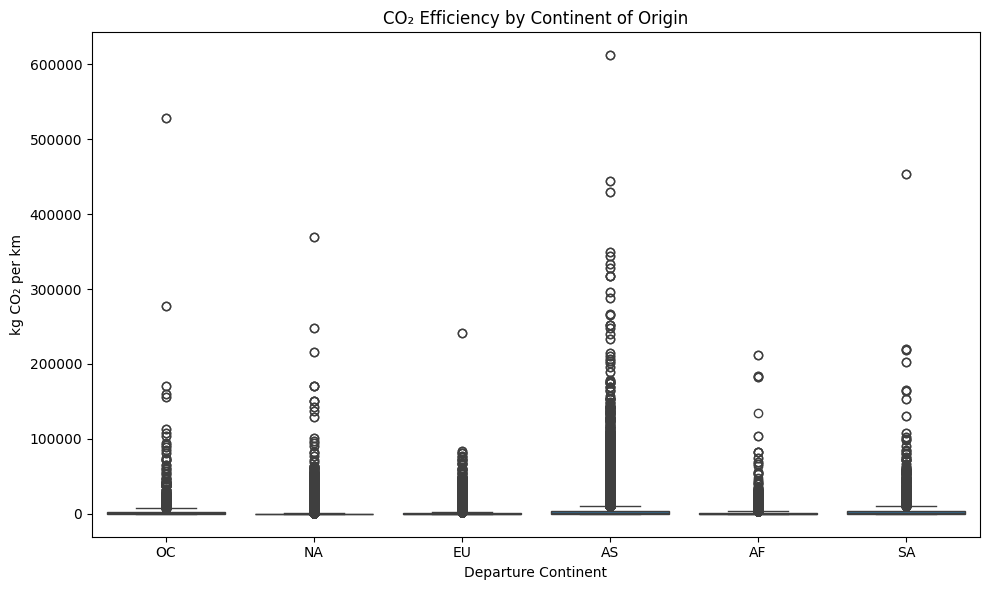

In [ ]:
# Simple boxplot for the breakdown by departing continent. We see a few outliers in the case of every continent, and visually
# it is difficult to determine any big difference other than Asia departures, so we will check with ANOVA
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='departure_continent', y='co2_per_distance')
plt.title('CO₂ Efficiency by Continent of Origin')
plt.ylabel('kg CO₂ per km')
plt.xlabel('Departure Continent')
plt.tight_layout()
plt.show()



In [9]:
#check if there is some significance generally. We see that there is, but we need to determine if there are any specific combinations

from scipy.stats import f_oneway

# Drop missing data
df_clean = df[['departure_continent', 'co2_per_distance']].dropna()

# Group by continent
grouped = df_clean.groupby('departure_continent')['co2_per_distance'].apply(list)

# Run one-way ANOVA
f_stat, p_value = f_oneway(*grouped)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")
print("This shows that there is significantly significance of impact of the departure continent")

ANOVA F-statistic: 2362.4397, p-value: 0.0000e+00
This shows that there is significantly significance of impact of the departure continent


In [5]:
# Digging in deeper to see if this is true for different groupings
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_clean['co2_per_distance'],
                          groups=df_clean['departure_continent'],
                          alpha=0.05)
print(tukey.summary())
#if we reject, then we can assume there is a meaningful difference

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
    AF     AS  3688.7329    0.0  3418.1279   3959.338   True
    AF     EU  -729.0592    0.0  -983.5546  -474.5637   True
    AF     NA  -754.2943    0.0 -1007.2511  -501.3375   True
    AF     OC  3170.9309    0.0  2689.1577  3652.7042   True
    AF     SA   3002.654    0.0  2619.9712  3385.3368   True
    AS     EU -4417.7921    0.0 -4551.4411 -4284.1431   True
    AS     NA -4443.0272    0.0 -4573.7225 -4312.3319   True
    AS     OC   -517.802  0.008  -948.1502   -87.4538   True
    AS     SA  -686.0789    0.0 -1001.5789  -370.5789   True
    EU     NA   -25.2351 0.9718  -118.0904    67.6201  False
    EU     OC  3899.9901    0.0   3479.585  4320.3951   True
    EU     SA  3731.7132    0.0  3429.9167  4033.5096   True
    NA     OC  3925.2252    0.0  3505.7498  4344.7006   True
    NA     SA  3756.9483

## CO₂ Efficiency by Departure Continent – Statistical Summary
We performed a Tukey HSD test to compare the mean CO₂ emissions per kilometer (co2_per_distance) between flights originating from different continents. The test revealed several statistically significant differences:

Flights originating from Asia have significantly higher CO₂/km compared to all other continents. This suggests lower operational efficiency, potentially due to older aircraft, less efficient routing, or longer average distances with fewer passengers.

Flights from Africa also show significantly higher emissions than most other continents, though not as extreme as Asia.

North America and Europe show no statistically significant difference in mean CO₂/km (p = 0.97), supporting the hypothesis that both continents operate similarly efficient fleets.

Oceania and South America generally fall in the middle range, with some significant differences from the higher-emission continents (e.g., Asia and Africa), but not consistently distinct from each other.

These results support the assumption that North American flights are relatively efficient, though not uniquely so compared to Europe. The largest inefficiencies appear to originate from Asia and Africa.